## Create non IID dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from lib.generate_timeseries import Periodic_1d
import torch
from collections import Counter
from matplotlib import cm
from torch.distributions import uniform
import pandas as pd
import os
import seaborn as sns


base_amps = [0.5,  1.0, 2.0, 10.0]
base_freqs = [0.1, 0.5, 1.0, 1.5]
base_freqs = [0.5]



In [60]:
###############################################################################
# Get amplitudes and frequencies according to drichlet distribution
###############################################################################

def create_meta(num_clients, base_amps, base_freqs, alpha, n = 100):
    """
    Create a metadata dictionary for clients with their respective
    amplitudes and frequencies.
    """
    alpha_vector_amps = [alpha] * len(base_amps)
    alpha_vector_freqs = [alpha] * len(base_freqs)
    meta = pd.DataFrame()
    for i in range(num_clients):
        param_dist_amp = np.random.dirichlet(alpha_vector_amps)
        param_dist_freq = np.random.dirichlet(alpha_vector_freqs)
        
        amps = np.random.choice(base_amps, p=param_dist_amp, size=n)
        freqs = np.random.choice(base_freqs, p=param_dist_freq, size=n)
        
        df = pd.DataFrame({
            'client_id': i,
            'amplitude': amps,
            'frequency': freqs,
            "alpha": alpha
        })
        meta = pd.concat([meta, df], ignore_index=True)
        
    return meta

In [ ]:
#########################################
# Set partitioning clients
#########################################

num_clients = 2
n = 1000

client_data_01 = create_meta(num_clients, base_amps, base_freqs, 0.1, n)
client_data_1 = create_meta(num_clients, base_amps, base_freqs, 1.0, n)
client_data_100 = create_meta(num_clients, base_amps, base_freqs, 100.0, n)

client_data = pd.concat([client_data_01, client_data_1, client_data_100], ignore_index=True)

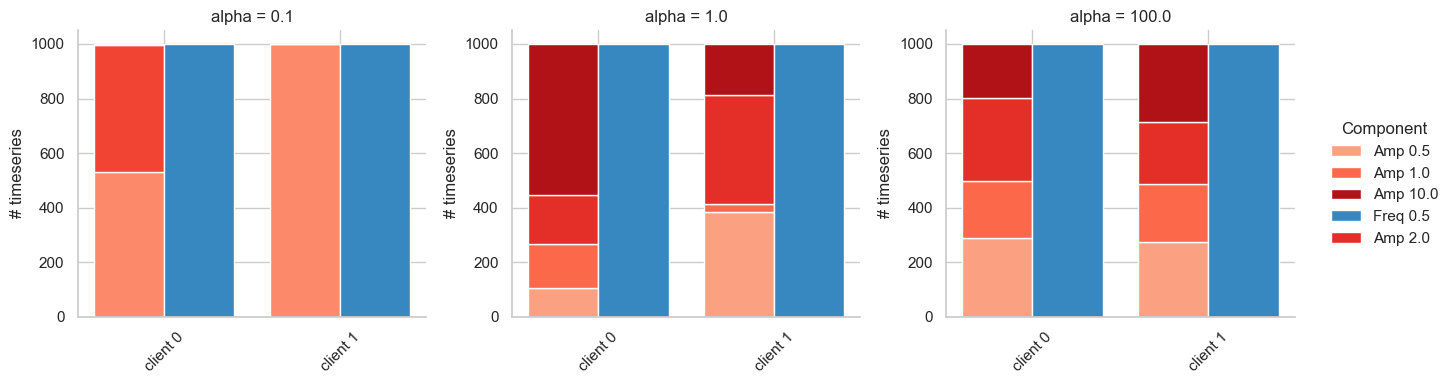

In [62]:
#########################################
# Plot partitioning clients
#########################################

# Ensure seaborn theme
sns.set(style='whitegrid')
%matplotlib inline
# Function to plot for each alpha
def plot_stacked(data, **kwargs):
    ax = plt.gca()
    clients = data['client_id'].unique()
    x = np.arange(len(clients))
    width = 0.4

    amp_counts = data.groupby(['client_id', 'amplitude']).size().unstack(fill_value=0).reindex(clients)
    freq_counts = data.groupby(['client_id', 'frequency']).size().unstack(fill_value=0).reindex(clients)

    amp_vals = amp_counts.columns.tolist()
    freq_vals = freq_counts.columns.tolist()
    colors_amp = [cm.Reds((i + 2) / (len(amp_vals) + 2)) for i in range(len(amp_vals))]
    colors_freq = [cm.Blues((i + 2) / (len(freq_vals) + 2)) for i in range(len(freq_vals))]

    bottom = np.zeros(len(clients))
    for j, val in enumerate(amp_vals):
        ax.bar(x - width/2, amp_counts[val], width, bottom=bottom,
               label=f"Amp {val}", color=colors_amp[j])
        bottom += amp_counts[val]

    bottom = np.zeros(len(clients))
    for j, val in enumerate(freq_vals):
        ax.bar(x + width/2, freq_counts[val], width, bottom=bottom,
               label=f"Freq {val}", color=colors_freq[j])
        bottom += freq_counts[val]

    ax.set_xticks(x)
    client_labels = [f"client {i}" for i in clients]
    ax.set_xticklabels(client_labels, rotation=45)
    # only set y label for the first plot
    ax.set_ylabel("# timeseries")
    # only set y label for the first plot
    

# Create the FacetGrid
g = sns.FacetGrid(client_data, col="alpha", col_wrap=3, sharey=False, height=4)
g.map_dataframe(plot_stacked)
g.add_legend(title="Component")
# legend outside of plot
g.legend.set_bbox_to_anchor((1.10, 0.5))
plt.tight_layout()
plt.show()


In [71]:
def get_dataset(amplitude, frequency, n_total_tp, max_t_extrap, n_samples=50, noise_weight=0):
    """
    Generate a dataset of periodic functions with given amplitude and frequency.
    """
    # Create time steps for extrapolation
    time_steps = torch.linspace(0, max_t_extrap, n_total_tp)
    
    # Create a uniform distribution for extrapolation time steps
    # Exclude the first time step (0.0) to avoid duplication

    distribution = uniform.Uniform(torch.Tensor([0.0]),torch.Tensor([max_t_extrap]))
    time_steps_extrap =  distribution.sample(torch.Size([n_total_tp-1]))[:,0]
    time_steps_extrap = torch.cat((torch.Tensor([0.0]), time_steps_extrap))
    time_steps_extrap = torch.sort(time_steps_extrap)[0]

    dataset_obj = None
    ##################################################################
    # Sample a periodic function

    dataset_obj = Periodic_1d(
        init_freq = frequency, init_amplitude = amplitude,
        final_amplitude = amplitude, final_freq = frequency, 
        z0 = 1.)

    ##################################################################


    dataset = dataset_obj.sample_traj(time_steps_extrap, n_samples = n_samples, 
        noise_weight = noise_weight)

    return dataset, time_steps_extrap


In [ ]:
#########################################
# Create combinations of datasets
#########################################

def create_dataset_with_combinations(combinations, n_total_tp, max_t_extrap, n_samples_per_combination):
    """
    Create datasets for each combination of amplitude and frequency.
    """
    datasets = []
    for amp, freq in combinations:
        dataset, time_steps_extrap = get_dataset(amp, freq, n_total_tp, max_t_extrap, n_samples=n_samples_per_combination)
        # make amp same size as dataset
        # no tensor 
        amp = np.full((dataset.shape[0],), amp)
        freq = np.full((dataset.shape[0],), freq)
        datasets.append((amp, freq, dataset, time_steps_extrap))
    return datasets



#########################################
# plot one sample from each combination
#########################################
def plot_all_combinations(datasets):
    """
    Plot one sample from each combination of amplitude and frequency.
    """
    plt.figure(figsize=(12, 8))
    for i, (amp, freq, dataset, time_steps_extrap) in enumerate(datasets):
        y = dataset[0, :, :].squeeze().cpu().numpy()  # take the first sample
        plt.subplot(4, 4, i + 1)
        plt.plot(time_steps_extrap.cpu().numpy(), y)
        plt.title(f"Amp: {amp[0]}, Freq: {freq[0]}")
        plt.xlabel('Time')
        plt.ylabel('Value')
    
    plt.tight_layout()
    plt.show()

In [ ]:
#########################################
# Merge all datasets for centralized training
#########################################
def merge_datasets(datasets):
    """
    Merge all datasets into one tensor.
    """
    merged_data = []
    amps = []
    freqs = []
    time_steps = []
    for amp, freq, dataset, time_steps_extrap in datasets:
        dataset_size = dataset.size()
        merged_data.append(dataset)
        # append content of amp and freq to the list in numpy 
        amps.extend(amp)  # reshape to column vector
        freqs.extend(freq)
        time_steps.append(time_steps_extrap)

    # Concatenate along the first dimension (samples)
    merged_data = torch.cat(merged_data, dim=0)
    return amps, freqs, merged_data, time_steps_extrap



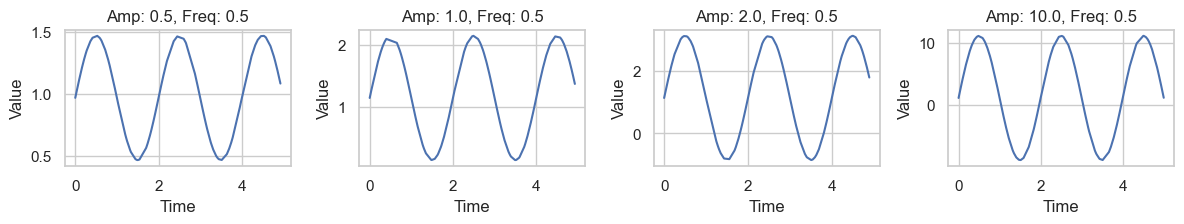

In [ ]:
#########################################
# Split into train and test sets
#########################################


def split_train_test(full_dataset, train_fraq = 0.8):
	amps, freqs, data, time_steps = full_dataset

	# shuffle the data
	indices = torch.randperm(data.size(0))
	data = data[indices]
	amps = torch.tensor(amps)[indices]
	freqs = torch.tensor(freqs)[indices]
	# time_steps is already sorted, so we don't shuffle it

	n_samples = data.size(0)
	print(f"Number of samples: {n_samples}")
	# amps
	print(amps)
	data_train = data[:int(n_samples * train_fraq)]
	data_test = data[int(n_samples * train_fraq):]
	amps_train = amps[:int(n_samples * train_fraq)]
	freqs_train = freqs[:int(n_samples * train_fraq)]
	amps_test = amps[int(n_samples * train_fraq):]
	freqs_test = freqs[int(n_samples * train_fraq):]
	time_steps_train = time_steps[:int(n_samples * train_fraq)]
	time_steps_test = time_steps[int(n_samples * train_fraq):]
	train = {
		'data': data_train,
		'amplitude': amps_train,
		'frequency': freqs_train,
		'time_steps': time_steps_train
	}
	test = {
		'data': data_test,
		'amplitude': amps_test,
		'frequency': freqs_test,
		'time_steps': time_steps_test
	}
	return train, test




Number of samples: 1200
tensor([10.0000, 10.0000,  1.0000,  ...,  2.0000,  0.5000, 10.0000],
       dtype=torch.float64)


In [ ]:

combinations = [(amp, freq) for amp in base_amps for freq in base_freqs]
# get 100 samples per combination
n_samples_per_combination = 300
n_total_tp = 100
max_t_extrap = 5.0  # maximum extrapolation time

datasets = create_dataset_with_combinations(combinations, n_total_tp, max_t_extrap, n_samples_per_combination)
plot_all_combinations(datasets)
full_dataset = merge_datasets(datasets)

# 2. Split into train and test
train, test = split_train_test(full_dataset, train_fraq = 0.8)

In [ ]:
#########################################
# Store
#########################################
def store_dataset(train, test, dataset_prefix, path_prefix):
    """
    Store the dataset to disk.
    """
    output_file_prefix = f"{path_prefix}/{dataset_prefix}"
    # if it doesn't exist, create the directory
    if not os.path.exists(f"{path_prefix}/{dataset_prefix}"):
        os.makedirs(f"{path_prefix}", exist_ok=True)

    # save the dataset to a file
    with open(f"{output_file_prefix}_train.pt", "wb") as f:
        torch.save(train["data"], f)
    with open(f"{output_file_prefix}_test.pt", "wb") as f:
        torch.save(test['data'], f)
    with open(f"{output_file_prefix}_train_amps.pt", "wb") as f:
        torch.save(train['amplitude'], f)
    with open(f"{output_file_prefix}_train_freqs.pt", "wb") as f:
        torch.save(train['frequency'], f)
    with open(f"{output_file_prefix}_test_amps.pt", "wb") as f:
        torch.save(test['amplitude'], f)
    with open(f"{output_file_prefix}_test_freqs.pt", "wb") as f:
        torch.save(test['frequency'], f)
    with open(f"{output_file_prefix}_time_steps_train.pt", "wb") as f:
        torch.save(train['time_steps'], f)
    with open(f"{output_file_prefix}_time_steps_test.pt", "wb") as f:
        torch.save(test['time_steps'], f)
    with open(f"{output_file_prefix}_time_steps.pt", "wb") as f:
         torch.save(train['time_steps'], f)
    
    # print message with colors
    print("\033[92mPeriodic dataset created and saved to disk.\033[0m")
    print(f"{output_file_prefix}_train.pt")
    print(f"{output_file_prefix}_test.pt")
    print(f"{output_file_prefix}_time_steps.pt")


# dataset_prefix = "periodic_nonidd"
# path_prefix = f"/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/data/{dataset_prefix}/"


# train_amps = train['amplitude']
# train_freqs = train['frequency']
# test_amps = test['amplitude']
# test_freqs = test['frequency']
# time_steps_train = train['time_steps']
# time_steps_test = test['time_steps']

# output_file_prefix = f"{path_prefix}/{dataset_prefix}"
# # if it doesn't exist, create the directory
# if not os.path.exists(f"{path_prefix}/{dataset_prefix}"):
#     os.makedirs(f"{path_prefix}", exist_ok=True)

# # save the dataset to a file
# with open(f"{output_file_prefix}_train.pt", "wb") as f:
#     torch.save(train["data"], f)
# with open(f"{output_file_prefix}_test.pt", "wb") as f:
#     torch.save(test['data'], f)
# with open(f"{output_file_prefix}_train_amps.pt", "wb") as f:
#     torch.save(train_amps, f)
# with open(f"{output_file_prefix}_train_freqs.pt", "wb") as f:
#     torch.save(train_freqs, f)
# with open(f"{output_file_prefix}_test_amps.pt", "wb") as f:
#     torch.save(test_amps, f)
# with open(f"{output_file_prefix}_test_freqs.pt", "wb") as f:
#     torch.save(test_freqs, f)
# with open(f"{output_file_prefix}_time_steps_train.pt", "wb") as f:
#     torch.save(time_steps_train, f)
# with open(f"{output_file_prefix}_time_steps_test.pt", "wb") as f:
#     torch.save(time_steps_test, f)
# with open(f"{output_file_prefix}_time_steps.pt", "wb") as f:
#     torch.save(time_steps_extrap, f)


# # print message with colors
# print("\033[92mPeriodic_nonidd dataset created and saved to disk.\033[0m")
# print(f"{output_file_prefix}_train.pt")
# print(f"{output_file_prefix}_test.pt")
# print(f"{output_file_prefix}_time_steps.pt")

Periodic_nonidd dataset created and saved to disk.
/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/data/periodic_nonidd//periodic_nonidd_train.pt
/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/data/periodic_nonidd//periodic_nonidd_test.pt
/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/data/periodic_nonidd//periodic_nonidd_time_steps.pt


In [92]:
# Read in stored files
train_data = torch.load(f"{output_file_prefix}_train.pt", weights_only=True)
test_data = torch.load(f"{output_file_prefix}_test.pt", weights_only=True)
amps_train = torch.load(f"{output_file_prefix}_train_amps.pt", weights_only=False)
freqs_train = torch.load(f"{output_file_prefix}_train_freqs.pt", weights_only=False)
amps_test = torch.load(f"{output_file_prefix}_test_amps.pt", weights_only=False)
freqs_test = torch.load(f"{output_file_prefix}_test_freqs.pt", weights_only=False)
time_steps_train = torch.load(f"{output_file_prefix}_time_steps_train.pt", weights_only=False)
time_steps_test = torch.load(f"{output_file_prefix}_time_steps_test.pt",  weights_only=False)


/var/folders/yx/rfhrpk093hz1gfwtn7qxt_180000gq/T/ipykernel_66376/3438534270.py:18: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(freqs_train, color='blue', label='Train', fill =True, alpha=0.5)
/var/folders/yx/rfhrpk093hz1gfwtn7qxt_180000gq/T/ipykernel_66376/3438534270.py:19: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(freqs_test, color='orange', label='Test', fill =True, alpha=0.5)
/var/folders/yx/rfhrpk093hz1gfwtn7qxt_180000gq/T/ipykernel_66376/3438534270.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/var/folders/yx/rfhrpk093hz1gfwtn7qxt_180000gq/T/ipykernel_66376/3438534270.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label st

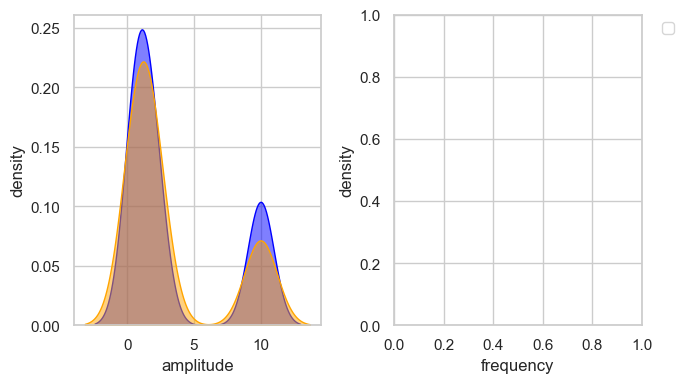

In [79]:
# plot distribution of amplitudes and frequencies in train and test set
def plot_distribution(amps_train, freqs_train, amps_test, freqs_test):
    """
    Plot the distribution of amplitudes and frequencies in train and test set.
    """
    plt.figure(figsize=(7, 4))
    
    # Amplitudes
    plt.subplot(1, 2, 1)
    sns.kdeplot(amps_train, color='blue', label='Train', fill =True, alpha=0.5)
    sns.kdeplot(amps_test, color='orange', label='Test', fill =True, alpha=0.5)
    plt.xlabel('amplitude')
    plt.ylabel('density')

    
    # Frequencies
    plt.subplot(1, 2, 2)
    sns.kdeplot(freqs_train, color='blue', label='Train', fill =True, alpha=0.5)
    sns.kdeplot(freqs_test, color='orange', label='Test', fill =True, alpha=0.5)
    plt.xlabel('frequency')
    plt.ylabel('density')
    plt.legend()
    # legend outside of plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
plot_distribution(amps_train, freqs_train, amps_test, freqs_test)

In [80]:
# density plot of amplitudes and frequencies
len(amps_train)

960

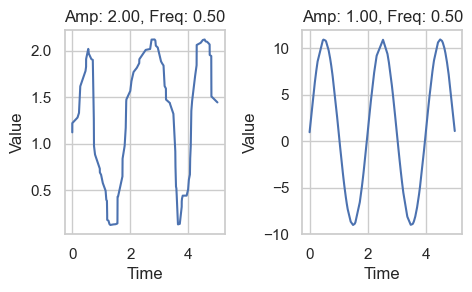

In [105]:
# visualize some of the train and test data
def visualize_data(data, time_steps, amps, freqs, n_samples=3):
    """
    Visualize some of the train and test data.
    """
    plt.figure(figsize=(12, 8))
    n_samples = min(n_samples, data.size(0))  # Ensure we don't exceed available samples
    for i in range(n_samples):
        y = data[i, :, :].squeeze().cpu().numpy()  # take the i-th sample
        plt.subplot(3, 5, i + 1)
        plt.plot(time_steps.cpu().numpy(), y)
        # make it scatter plot
        plt.title(f"Amp: {amps[i].item():.2f}, Freq: {freqs[i].item():.2f}")
        plt.xlabel('Time')
        plt.ylabel('Value')
    
    plt.tight_layout()
    plt.show()
visualize_data(test_data, time_steps_train, amps_train, freqs_train, n_samples=2)